<a href="https://colab.research.google.com/github/CoWoGeo/PUS2022_CWolk/blob/main/ProjectLanthamWolk/LIBusinessLicenses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Philadelphia L&I Business Licenses

Data and overview here: https://www.opendataphilly.org/dataset/licenses-and-inspections-business-licenses

City's data visualization (with helpful search tool) here: https://data.phila.gov/visualizations/li-business-licenses

This will be the foundational data set for our project. Our core data from this is every site that has ever had a junkyard license, plus every license attached to that parcel. The logic for this is that we know that there are far more operating junkyards than sites with active junkyard licenses (based on news coverage and the Scrapyard Task Force's own report) and there does not seem to be much enforcement of license renewals, so junkyards with lapsed licenses are a logical place to look. 

We also hope to look for sites that have never had junkyard licenses but whose business names and licenses make them likely candidates, such as having auto repair or part licenses and "scrap" or "junk" in the name. This might need to be a later project, though, as the dividing line between an auto repair or used tire place and a junkyard is blurry and we might need to figure out additional criteria such as parcel size, violations, types of complaints, etc.

## Order of operations:


1.   Import business licenses dataset
2.   Remove irrelevant columns, clean up rows with significant NaNs
3. Find most common irrelevant business license type (in this case, Rental) and remove it from the dataframe to make it smaller and more manageable
4. Extract all sites that have ever had junkyard licenses
5. Extract all sites that have active junkyard licenses for numeric context
6. Find a column to use to find all licenses for junkyard sites. This ended up being the geometry column because no other column was reliable or complete enough.
7. Create a geodataframe of sites with junkyard licenses and all other licenses for those locations.
8. Import Philadelphia Department of Records Parcel shapefile. 
9. Use Philadelphia Department of Records Parcels to merge correct parcel data and street addresses with license locations, replace point geometry of business licenses with parcel shape geometry.
10. Probably download this dataset and upload it to Google Drive so that we can use it in other notebooks without having to rerun all the very slow imports and loops.
11. Do some data analysis on the types of licenses and data quality.



# Importing and Installing Libraries

In [1]:
!apt install python3-rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 7 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-

In [2]:
! pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install cartoframes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 245 kB 4.8 MB/s 
     |████████████████████████████████| 1.1 MB 42.2 MB/s 
     |████████████████████████████████| 235 kB 21.5 MB/s 
     |████████████████████████████████| 7.8 MB 32.9 MB/s 
     |████████████████████████████████| 16.6 MB 73 kB/s 
  Created wheel for carto: filename=carto-1.11.3-py3-none-any.whl size=35088 sha256=45fa74b3cba9826bf5e9221c674b2e30e87e75628a24a2536a3eafd8ab2d999c
  Stored in directory: /root/.cache/pip/wheels/6b/a3/41/90fa4334cd280f91d17226f36db7a34b12902f7e5b281afb84
  Created wheel for pyrestcli: filename=pyrestcli-0.6.11-py3-none-any.whl size=8496 sha256=920fa6d056cf8332b77d0685550caaedd890139da6fac5fac45d5d33816700dc
  Stored in directory: /root/.cache/pip/wheels/92/fc/98/2e46573b8e1bbe953345578314c765d3ecdc9532450bb90d79
Successfully built carto pyrestcli


In [4]:
!pip install geopandas
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd

In [6]:
import cartoframes as cf

In [7]:
import matplotlib.pyplot as plt

In [8]:
from shapely.geometry import Point

In [9]:
import numpy as np

In [10]:
import pandas as pd

# Importing and Exploring Business Licenses Data

In [11]:
licenses = gpd.GeoDataFrame.from_file("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+business_licenses&filename=business_licenses&format=shp&skipfields=cartodb_id")

In [12]:
#I really want to edit the link to import just the columns I want and cut the
#rental licenses before importing them to save time and storage. But how?
#licenses = gpd.GeoDataFrame.from_file("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+business_licenses&filename=business_licenses&format=shp&skipfields=cartodb_id&WHERE+licensetyp==Rental=False)

In [13]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 394993 entries, 0 to 394992
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    394993 non-null  int64   
 1   addressobj  375219 non-null  float64 
 2   address     377743 non-null  object  
 3   unit_type   115886 non-null  object  
 4   unit_num    115351 non-null  object  
 5   zip         377717 non-null  object  
 6   censustrac  377220 non-null  object  
 7   parcel_id_  375910 non-null  object  
 8   opa_accoun  367588 non-null  object  
 9   opa_owner   367333 non-null  object  
 10  licensenum  394993 non-null  object  
 11  revenuecod  394993 non-null  object  
 12  licensetyp  394993 non-null  object  
 13  rentalcate  229655 non-null  object  
 14  initialiss  394993 non-null  object  
 15  mostrecent  394993 non-null  object  
 16  expiration  385907 non-null  object  
 17  inactiveda  227381 non-null  object  
 18  licensesta  3949

In [14]:
# yourdf = yourdf.drop(['columnheading1', 'columnheading2'], axis=1)

## Cleaning Business License Data

Here is the metadata page: https://metadata.phila.gov/#home/datasetdetails/5543865a20583086178c4ed2/representationdetails/5e985a5e344ed50018936bb8/

A useful explanation for OPA Account Number: "Office of Property Assessment Account Number' Every land parcel within the City of Philadelphia is assigned a unique account number from OPA. This number stays with the property for as long as the deed is held by the same owner. Once a property transfers ownership, it is assigned a new OPA account number and the old one is retired.

"This field can be used as a join key for various city datasets. It is also sometimes known as the 'BRT' number or within some datasets coming directly from OPA is also called the 'PARCEL_NUMBER'. (Other departments may use different internal 'Parcel Numbers', so please verify before using)"

This is both incredibly confusing/messy and useful: multiple OPA Account Numbers being tagged to the same address will show us that the property changed hands. (This is often very slow to show up in records, in my experience, though!)

POSSE JOBI: "Objectid and join field for related records" But there are other fields they say are join fields and other objectids!

In [15]:
# drop multiple columns by index
cols  = licenses.columns
licenses.drop(columns =cols[27:37], inplace=True)

In [16]:
licenses = licenses.drop(columns=["numberofun", "owneroccup"], axis=1)

In [17]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 394993 entries, 0 to 394992
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    394993 non-null  int64   
 1   addressobj  375219 non-null  float64 
 2   address     377743 non-null  object  
 3   unit_type   115886 non-null  object  
 4   unit_num    115351 non-null  object  
 5   zip         377717 non-null  object  
 6   censustrac  377220 non-null  object  
 7   parcel_id_  375910 non-null  object  
 8   opa_accoun  367588 non-null  object  
 9   opa_owner   367333 non-null  object  
 10  licensenum  394993 non-null  object  
 11  revenuecod  394993 non-null  object  
 12  licensetyp  394993 non-null  object  
 13  rentalcate  229655 non-null  object  
 14  initialiss  394993 non-null  object  
 15  mostrecent  394993 non-null  object  
 16  expiration  385907 non-null  object  
 17  inactiveda  227381 non-null  object  
 18  licensesta  3949

In [18]:
licensetype = licenses["licensetyp"]
licensetype.describe()

count     394993
unique        53
top       Rental
freq      251891
Name: licensetyp, dtype: object

There are 53 types of licenses in the data set, with Rental as the most frequent. Maybe I should remove those to pare down the data set further?

In [19]:
# Removing the many Rental records from the dataframe
licenses = licenses[licenses["licensetyp"].str.contains("Rental") == False]

In [20]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 143102 entries, 2 to 394982
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    143102 non-null  int64   
 1   addressobj  123682 non-null  float64 
 2   address     126401 non-null  object  
 3   unit_type   36605 non-null   object  
 4   unit_num    36397 non-null   object  
 5   zip         126400 non-null  object  
 6   censustrac  126213 non-null  object  
 7   parcel_id_  124978 non-null  object  
 8   opa_accoun  122190 non-null  object  
 9   opa_owner   122006 non-null  object  
 10  licensenum  143102 non-null  object  
 11  revenuecod  143102 non-null  object  
 12  licensetyp  143102 non-null  object  
 13  rentalcate  0 non-null       object  
 14  initialiss  143102 non-null  object  
 15  mostrecent  143102 non-null  object  
 16  expiration  134016 non-null  object  
 17  inactiveda  79235 non-null   object  
 18  licensesta  1431

In [21]:
licensetype.describe()

count     394993
unique        53
top       Rental
freq      251891
Name: licensetyp, dtype: object

The next most frequent is "Vacant Residential Property / Lot." We need this for later because fly-by-night scrapyards are likely on vacant lots, but we don't need it now. Now we know that there are 34,955 vacant lots in Philadelphia!

## Creating a dataframe of junkyard licenses

In [22]:
licensedjunk = licenses[licenses["licensetyp"].str.contains("Auto Wrecking / Junk Yard")]

In [23]:
licensedjunk.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 274 entries, 13112 to 394342
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    274 non-null    int64   
 1   addressobj  270 non-null    float64 
 2   address     270 non-null    object  
 3   unit_type   34 non-null     object  
 4   unit_num    34 non-null     object  
 5   zip         270 non-null    object  
 6   censustrac  270 non-null    object  
 7   parcel_id_  239 non-null    object  
 8   opa_accoun  230 non-null    object  
 9   opa_owner   230 non-null    object  
 10  licensenum  274 non-null    object  
 11  revenuecod  274 non-null    object  
 12  licensetyp  274 non-null    object  
 13  rentalcate  0 non-null      object  
 14  initialiss  274 non-null    object  
 15  mostrecent  274 non-null    object  
 16  expiration  274 non-null    object  
 17  inactiveda  186 non-null    object  
 18  licensesta  274 non-null    object 

I could have just done that to start with, but all the datacleaning above will make the licenses dataframe smaller and easier to work with in future steps.

In [24]:
nogeometry = licensedjunk[licensedjunk["geometry"].isna()]
nogeometry

,objectid,addressobj,address,unit_type,unit_num,zip,censustrac,parcel_id_,opa_accoun,opa_owner,...,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,council_di,posse_jobi,geometry
85580,84641,NaN,None,None,None,None,None,None,None,None,...,None,LAM AUTO SALES CO,Company,LAM AUTO SALES CO,"1901 WESTMORELAND ST PHILADELPHIA, PA 19140 USA",NaN,NaN,None,9263633,None
97489,104242,NaN,None,None,None,None,None,None,None,None,...,None,KNOCK OUT AUTO PARTS LLC,Company,KNOCK OUT AUTO PARTS LLC,"3201 E TIOGA ST PHILADELPHIA, PA 19134 USA",NaN,NaN,None,9340939,None
104665,106574,NaN,None,None,None,None,None,None,None,None,...,None,PORT RICHMOND AUTO INC,Company,PORT RICHMOND AUTO INC,"3950 N DELAWARE AVE PHILADELPHIA, PA USA",NaN,NaN,None,9334382,None
109147,97271,NaN,None,None,None,None,None,None,None,None,...,CREEDON,CREEDON KEVIN,Individual,KEVINS USED AUTO PARTS,"423 W LUZERNE ST PHILADELPHIA, PA 19140 USA",NaN,NaN,None,9307259,None


An illustration of how messy this data is! I looked up Kevin's Used Auto Parts, one of the entries missing most of the data and with an inactive Junk Yard license, in the city API and found a second entry with the same business name and an inactive license for towing. However, that business had the address of 990 Spring Garden St, which is a real estate company. I searched 423 W. Luzerne St and got a few auto parts companies with no obvious name. However, satellite images show some junkyards at the pin for 423 W. Luzerne St. (Incidentally, next to a police station.) Then I searched the owner, Kevin Creedon, and found another inactive junkyard license for 	4085 RICHMOND ST and a license at 4087 Richmond St. There is nothing there because it is the little space between Richmond St, Frankford Creek, and multiple freight rail lines.

*   1901 WESTMORELAND ST/Lam Auto Sales: Inactive. There is also a closed business license for Lam Auto Sales "Motor Vehicle Repair / Retail Mobile Dispensing" at that address with more data. Google Streetview shows a raggedy abandoned-looking warehouse.

*   3201 E. Tioga/Knock Out Auto Parts: No other entries. It's sort of a vacant lot by the PRPA HQ. There's another auto shop on that same big lot, but it has a different address and its own entry.

*   3950 N DELAWARE AVE PHILADELPHIA / Port Richmond Auto Company: No other entries for that address, searching the name comes up with 4085 RICHMOND ST, which has an inactive junk yard license with the same business name. 4085 Richmond St is the same creekside address as above, but this is a different entry!

3950 Delaware Ave: Aha! This is an alias for 3950 N. Delaware Ave. Google maps actually shows a big scrapyard here. There are active junkyard and hazmat materials licenses for a company called "Final Destination, Inc." using this address as their business license and 4085 as their location. Very creepy. They are actually there on Google Streetview, though. Their licenses seem to overlap with the other licenses at 4085 Richmond St.

4000 N. Delaware Ave: another 4085 Richmond St location is registered here. Searching that address gets 3 licenses for another business, A AND B Scrap Metal at 9200 JAMES ST up in the Holmesburg neighborhood. These are all inactive, but there looks to be a junkyard attached to a few autobody/used car shops at 9200-9240 James St. Searching that census tract returns a ton of inactive licenses for various businesses, some property rental licenses, and an active dumpster license.

This tells me that I don't really need to worry about these because the information is basically redundant and very confusing.






In [25]:
#deleting those 4 null rows
licensedjunk = licensedjunk[licensedjunk["geometry"].notna()]

So now I have 269 rows. However, this doesn't necessarily mean 269 unique locations, because the data is so bad and a site can have multiple entries for licenses that stopped and started or changed names.

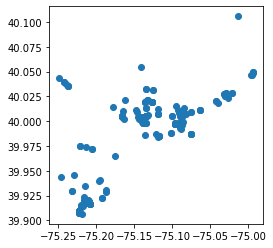

In [26]:
#plotting it just to look
licensedjunk.plot()

In [27]:
#just a little exploration
licensedjunk["licensesta"].head()



13112    Inactive
13177    Inactive
85092    Inactive
85093    Inactive
85095    Inactive
Name: licensesta, dtype: object

### Creating Dataframe of active junkyard licenses for later and comparison

In [28]:
#extracting active junkyard licenses
activejunk = licensedjunk[licensedjunk["licensesta"] == "Active"]

In [29]:
activejunk

,objectid,addressobj,address,unit_type,unit_num,zip,censustrac,parcel_id_,opa_accoun,opa_owner,...,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,council_di,posse_jobi,geometry
85289,84757,15803921.0,1 SHAWMONT AVE,None,None,19128-4200,216,515757,884634851,"ROSCIOLI FRANK M, ROSCIOLI LOUIS J",...,ROSCIOLI,ROSCIOLI LOUIS,Individual,ROSCIOLI LOUIS,"3441 SUNNYSIDE AVE PHILADELPHIA, PA 19129 USA",2.668619e+06,268779.631415,4,9264966,POINT (-75.24905 40.04394)
85294,84762,15378295.0,6740 ESSINGTON AVE,None,None,19153-3408,9809,177271,884161400,"ESSINGTON AVE AUTO, PARTNERS LP",...,None,ESSINGTON AVENUE AUTO PARTS INC,Company,ESSINGTON AVENUE AUTO PARTS INC,"712 E PROVIDENCE RD ALDAN, PA 19018 USA",2.677437e+06,219851.930518,2,9272074,POINT (-75.22257 39.90900)
85341,84774,15429790.0,5345 WHITBY AVE,None,None,19143-4133,72,101558,884465687,"IVERY HAROLD JR, IVERY LISA MARIE",...,None,HAROLDS USED AUTO PARTS INC,Company,HAROLDS USED AUTO PARTS INC,"5347 WHITBY AVE PHILADELPHIA, PA 19143 USA",2.675150e+06,233278.953512,3,9260983,POINT (-75.22935 39.94602)
85395,84791,15925832.0,3101 S 61ST ST,#,B,19153-3588,9809,480765,884790012,HPA INVESTMENTS LLC,...,None,CENTURY MOTORS INC,Company,CARTEL DOUBLE DISCOUNT,"6110 W PASSYUNK AVE PHILADELPHIA, PA 19153 USA",2.679103e+06,225114.366664,3,9247476,POINT (-75.21610 39.92331)
85437,84796,15721725.0,3100 S 61ST ST,None,None,19153-3516,9809,-884790010,884790010,BURBANK ASSOCIATES,...,AVERONA,AVERONA MICHAEL,Individual,AVERONA MICHAEL,"6101 W PASSYUNK AVE PHILADELPHIA, PA 19143 USA",2.680518e+06,224125.914021,3,9351773,POINT (-75.21116 39.92048)
85670,84659,15823985.0,4921 COTTMAN AVE,None,None,19135-1431,381,465559,884251590,THOMPSON BROS PROPERTIES,...,None,COTTMAN USED AUTO PARTS INC,Company,COTTMAN USED AUTO PARTS INC,"12418 MEDFORD RD PHILADELPHIA, PA 19154 USA",2.729512e+06,264460.711176,6,9265997,POINT (-75.03214 40.02715)
85786,84885,15706767.0,4534 HEDGE ST,None,None,19124-3720,294,446091,884344655,KARR GARY,...,None,G M KARR INC,Company,G M KARR INC,"4534 HEDGE ST PHILADELPHIA, PA 19124 USA",2.715136e+06,258996.891088,7,9266060,POINT (-75.08404 40.01337)
110810,112824,15771972.0,6247 W PASSYUNK AVE,None,None,19153-0000,9809,77818,882971295,"NGO RICHARD, NGO STEVEN",...,None,MATTHEWS ALL FOREIGN AUTO PARTS INC,Company,MATTHEWS ALL FOREIGN AUTO PARTS INC,"6257 PASSYUNK AVE PHILADELPHIA, P...",2.679286e+06,223056.180343,3,9327153,POINT (-75.21566 39.91764)
126898,118818,15733154.0,4085 RICHMOND ST,None,None,19137-1419,378,598493,None,None,...,None,FINAL DESTINATION INC,Company,FINAL DESTINATION INC,"3950 DELAWARE AVE PHILADELPHIA, PA 19137 USA",2.717820e+06,249676.170291,6,9418669,POINT (-75.07547 39.98757)
127614,117861,15414462.0,2501 S 28TH ST,None,None,19145-4010,36,250085,885890660,"WALSH MATTHEW J, WALSH MARK G",...,None,MATTHEWS ALL FOREIGN AUTO PARTS INC,Company,MATTHEWS ALL FOREIGN AUTO PARTS INC,"6257 PASSYUNK AVE PHILADELPHIA, P...",2.685631e+06,224894.209611,2,9387222,POINT (-75.19285 39.92218)


There are 52 entries with active junkyard licenses. This probably corresponds better to unique sites than the all licenses data, but we'll find out!

In [30]:
licensedjunk.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 270 entries, 13112 to 394342
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    270 non-null    int64   
 1   addressobj  270 non-null    float64 
 2   address     270 non-null    object  
 3   unit_type   34 non-null     object  
 4   unit_num    34 non-null     object  
 5   zip         270 non-null    object  
 6   censustrac  270 non-null    object  
 7   parcel_id_  239 non-null    object  
 8   opa_accoun  230 non-null    object  
 9   opa_owner   230 non-null    object  
 10  licensenum  270 non-null    object  
 11  revenuecod  270 non-null    object  
 12  licensetyp  270 non-null    object  
 13  rentalcate  0 non-null      object  
 14  initialiss  270 non-null    object  
 15  mostrecent  270 non-null    object  
 16  expiration  270 non-null    object  
 17  inactiveda  182 non-null    object  
 18  licensesta  270 non-null    object 

In [31]:
licensedjunk.nunique()

objectid      270
addressobj    144
address       121
unit_type       1
unit_num       12
zip            98
censustrac     48
parcel_id_    120
opa_accoun    115
opa_owner     112
licensenum    270
revenuecod      1
licensetyp      1
rentalcate      0
initialiss    239
mostrecent    245
expiration    107
inactiveda     64
licensesta      5
legalfirst     76
legallastn     82
legalname     236
legalentit      2
business_n    244
business_m    221
geocode_x     126
geocode_y     126
council_di     13
posse_jobi    270
geometry      126
dtype: int64

Only 125 unique geometry points out of 269 rows! You can also see that almost every other unique identifier is missing rows. Addressobj has the most nuniques, though, so I'm going to hope that's the most comprehensive.

In [32]:
activejunk.nunique()

objectid      52
addressobj    48
address       44
unit_type      1
unit_num       8
zip           40
censustrac    17
parcel_id_    46
opa_accoun    43
opa_owner     43
licensenum    52
revenuecod     1
licensetyp     1
rentalcate     0
initialiss    51
mostrecent    46
expiration    29
inactiveda     0
licensesta     1
legalfirst     8
legallastn     8
legalname     50
legalentit     2
business_n    50
business_m    50
geocode_x     45
geocode_y     45
council_di     7
posse_jobi    52
geometry      45
dtype: int64

## Getting Every License Attached to Known Junkyard Locations

In [33]:
#discovering that object ID won't pull everything related to a location.
testrun = licenses[licenses["objectid"] == 363387]
testrun

,objectid,addressobj,address,unit_type,unit_num,zip,censustrac,parcel_id_,opa_accoun,opa_owner,...,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,council_di,posse_jobi,geometry
361183,363387,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,HELPING HANDS RECYCLING INC,Company,HELPING HANDS RECYCLING INC,"2335 WHEATSHEAF LN PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,251510800,POINT (-75.09015 39.99912)


In [34]:
#addressobj is better than object ID
testrun2 = licenses[licenses["addressobj"] == 15410490.0]
testrun2

,objectid,addressobj,address,unit_type,unit_num,zip,censustrac,parcel_id_,opa_accoun,opa_owner,...,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,council_di,posse_jobi,geometry
79117,79302,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,ATLANTIC SYSTEMS INC,Company,ATLANTIC SYSTEMS INC,"2201 E BUTLER ST PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,9267345,POINT (-75.09015 39.99912)
80270,81275,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,ATLANTIC SYSTEMS INC,Company,ATLANTIC SYSTEMS INC,"2201 E BUTLER ST PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,9256703,POINT (-75.09015 39.99912)
83216,83661,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,ATLANTIC SYSTEMS INC,Company,ATLANTIC SYSTEMS INC,"2201 E BUTLER ST PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,9259030,POINT (-75.09015 39.99912)
174785,175931,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,DIVERSIFIED TOWING & RECOVERY INC,Company,DIVERSIFIED TOWING & RECOVERY INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,9518747,POINT (-75.09015 39.99912)
174786,175932,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,DIVERSIFIED TOWING & RECOVERY INC,Company,DIVERSIFIED TOWING & RECOVERY INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,9518748,POINT (-75.09015 39.99912)
174787,175933,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,DIVERSIFIED TOWING & RECOVERY INC,Company,DIVERSIFIED TOWING & RECOVERY INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,9518749,POINT (-75.09015 39.99912)
191092,190906,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,GREENDOG RECYCLING INC,Company,GREENDOG RECYCLING INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,9531043,POINT (-75.09015 39.99912)
191093,190907,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,GREENDOG RECYCLING INC,Company,GREENDOG RECYCLING INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,9531044,POINT (-75.09015 39.99912)
279366,267860,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,GREENDOG RECYCLING INC,Company,GREENDOG RECYCLING INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,39032729,POINT (-75.09015 39.99912)
292943,301727,15410490.0,2335 WHEATSHEAF LN,None,None,19137-1025,382,295956,884195003,NGUYEN APRIL,...,None,GREENDOG RECYCLING INC,Company,GREENDOG RECYCLING INC,"2335 WHEATSHEAF LANE PHILADELPHIA, PA 19137 USA",2.713581e+06,253759.308312,1,52446909,POINT (-75.09015 39.99912)


In [35]:
#licensedjunk_2[~licensedjunk_2.business_n.isin(licensedjunk_all["business_n"])]

In [36]:
#gathering licenses by matching by business name
licensedjunk_bizname = licenses[licenses.business_n.isin(licensedjunk["business_n"])]
licensedjunk_bizname.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 826 entries, 13112 to 394342
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    826 non-null    int64   
 1   addressobj  739 non-null    float64 
 2   address     751 non-null    object  
 3   unit_type   138 non-null    object  
 4   unit_num    138 non-null    object  
 5   zip         751 non-null    object  
 6   censustrac  751 non-null    object  
 7   parcel_id_  709 non-null    object  
 8   opa_accoun  689 non-null    object  
 9   opa_owner   689 non-null    object  
 10  licensenum  826 non-null    object  
 11  revenuecod  826 non-null    object  
 12  licensetyp  826 non-null    object  
 13  rentalcate  0 non-null      object  
 14  initialiss  826 non-null    object  
 15  mostrecent  826 non-null    object  
 16  expiration  798 non-null    object  
 17  inactiveda  489 non-null    object  
 18  licensesta  826 non-null    object 

In [37]:
# matching by address obj
licensedjunk_adreso = licenses[licenses.addressobj.isin(licensedjunk["addressobj"])]
licensedjunk_adreso.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 765 entries, 418 to 394342
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    765 non-null    int64   
 1   addressobj  765 non-null    float64 
 2   address     765 non-null    object  
 3   unit_type   102 non-null    object  
 4   unit_num    102 non-null    object  
 5   zip         765 non-null    object  
 6   censustrac  765 non-null    object  
 7   parcel_id_  718 non-null    object  
 8   opa_accoun  691 non-null    object  
 9   opa_owner   691 non-null    object  
 10  licensenum  765 non-null    object  
 11  revenuecod  765 non-null    object  
 12  licensetyp  765 non-null    object  
 13  rentalcate  0 non-null      object  
 14  initialiss  765 non-null    object  
 15  mostrecent  765 non-null    object  
 16  expiration  728 non-null    object  
 17  inactiveda  424 non-null    object  
 18  licensesta  765 non-null    object  


I get more unique address objects when I match by business name and more unique business names when I match by address object, which means that either method misses some of the other. However, it's not clear whether all those uniques are important because this dataset has a lot of redundancies, inconsistent data entries for the same info, and simply messy info.

In [38]:
# I get more unique address obj when I match by business names.
licensedjunk_bizname["addressobj"].nunique()

199

In [39]:
#same number of of unique addressobj as in licensedjunk. Except licensedjunk 
#had 269 licenses. Is that a good sign?
licensedjunk_adreso["addressobj"].nunique()

144

In [40]:
#unique business names matching by business name
licensedjunk_bizname["business_n"].nunique()

244

In [41]:
#unique business names matching by address obj. Way more!
licensedjunk_adreso["business_n"].nunique()

384

In [42]:
licensedjunk_bizname["geometry"].nunique()

172

In [43]:
licensedjunk_adreso["geometry"].nunique()

126

Above, you can see that parcel values are a mess!!! Non uniform string length, negative numbers, missing values... Parcel -884790010 is actually that business's OPA account id. I used the data visualization tool to explore how parcels and addresses are used throughout the dataset and found many parcel IDs switched with OPA accounts, but not consistently enough to use that to fix it, especially as the OPA account data has its own problems (see below).

Gah, neither of these is an obvious choice to capture all the information. Though number of unique in either category doesn't necessarily guarantee a more complete dataset. The uniqueness can just be typos, different spellings, redundancies, mixups of information, etc that add disorder without adding relevant information. Geometry is more computationally intense but seems like the safest match given the holes and inconsistencies in address object and business name. The risk is if points are misentered in such a way that they won't match for the same location, but the results should tell me if that's a huge problem.

In [44]:
# matching licenses by geometry
junkyards_lic = licenses[licenses.geometry.isin(licensedjunk["geometry"])]

In [45]:
junkyards_lic.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 866 entries, 418 to 394342
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    866 non-null    int64   
 1   addressobj  844 non-null    float64 
 2   address     866 non-null    object  
 3   unit_type   108 non-null    object  
 4   unit_num    108 non-null    object  
 5   zip         866 non-null    object  
 6   censustrac  866 non-null    object  
 7   parcel_id_  819 non-null    object  
 8   opa_accoun  791 non-null    object  
 9   opa_owner   791 non-null    object  
 10  licensenum  866 non-null    object  
 11  revenuecod  866 non-null    object  
 12  licensetyp  866 non-null    object  
 13  rentalcate  0 non-null      object  
 14  initialiss  866 non-null    object  
 15  mostrecent  866 non-null    object  
 16  expiration  821 non-null    object  
 17  inactiveda  476 non-null    object  
 18  licensesta  866 non-null    object  


Wooo, there are more unique business names in this matching strategy than the others, so I probably didn't lose useful data.

In [46]:
junkyards_lic["geometry"].nunique()

126

In [47]:
junkyards_lic["business_n"].nunique()

422

I imported the Philadelphia parcel data/map to compare it to this. On https://atlas.phila.gov/3100%20S%2061ST%20ST I figured out that one location with an OPA account as its parcel number has the official parcel number 047S220022. In the parcel dataset, that is in the MAPREG column. More below...

# Philly Parcels GeoDataframe

Now that I have all the locations with known junkyard licenses and all their relevant permits (I hope!), I'm going to add those parcel columns from the parcel dataset. I think it'll make it easier if I do this before I add in all the violations.

MAPREG is the column in the parcel dataset that matches the parcel section of Atlas Philly (the public website of Philly real estate data and deeds) https://atlas.phila.gov/. The PARCEL column in business licenses is very strange (apparently negatives aren't an aberration) and doesn't match this dataset at all, column-wise. I can't use PARCEL columns or street addresses (also a mess) to join the business licenses to any other dataset. However, the business license data is points and the parcel data is shapes/polygons, so I should be able to connect them by business license locations that fall within parcel polygons.

The Philly Parcels dataset is huge! After importing it once, I imported only a conservative estimate of the columns I think I might need.

In [48]:
#importing Philly Parcel data, with only useful columns
phillyparcels = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/datasets/1c57dd1b3ff84449a4b0e3fb29d3cafd_0.zip")[["ADDR_SOURC", "MAPREG", 
                                       "RECMAP", "PARCEL",
                                        "PWD_REVIEW", "DOR_REVIEW", "geometry"]]

In [49]:
phillyparcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 606508 entries, 0 to 606507
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ADDR_SOURC  600296 non-null  object  
 1   MAPREG      606353 non-null  object  
 2   RECMAP      606342 non-null  object  
 3   PARCEL      606142 non-null  object  
 4   PWD_REVIEW  25008 non-null   object  
 5   DOR_REVIEW  25351 non-null   object  
 6   geometry    606482 non-null  geometry
dtypes: geometry(1), object(6)
memory usage: 32.4+ MB


##  Plotting Junkyard Licenses Over Parcels

In [50]:
#plotting the parcels, took forever because there are so many!
#phillyparcels.plot()

The test plot below warns me of a problem to deal with: there are so many more parcels in Philadelphia than scrapyards that they overwhelm the map and take forever to load. I can't just get rid of most of them, though, because I might need them and they provide informational context (such as the ability to calculate city area with things like streets and rivers removed). I'll probably just extract the relevant parcels into a separate layer later.

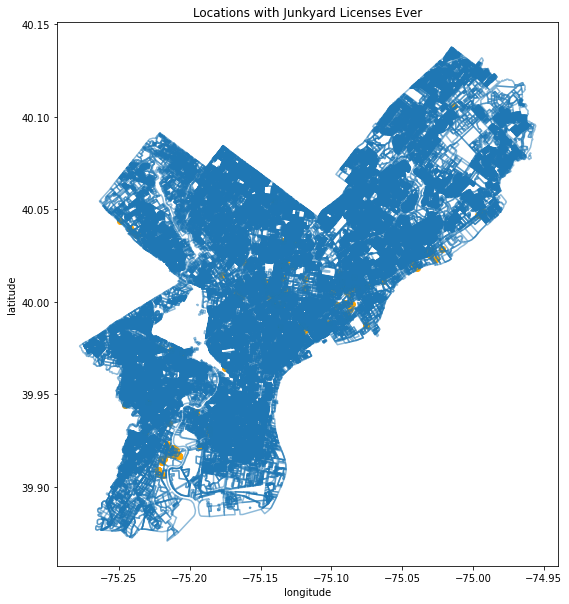

In [51]:
#plotting licensed junkyard sites over parcels
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
phillyparcels.boundary.plot(ax=ax, alpha=0.5)
plt.title("Locations with Junkyard Licenses Ever")
licensedjunk.plot(ax=ax, c="Orange", alpha=1);

In [52]:
#looking at that parcel that had a negative parcel code in the license data
weird = phillyparcels[phillyparcels["MAPREG"]=="047S220022"]
print(weird)

            ADDR_SOURC      MAPREG  RECMAP PARCEL PWD_REVIEW DOR_REVIEW  \
413266  3103 S 61ST ST  047S220022  047S22   0022       None       None   

                                                 geometry  
413266  POLYGON ((-75.21140 39.91971, -75.21147 39.919...  


# Projecting Layers

In [53]:
#checking the CRS, and kind of surprisingly, it is unprojected.
#Should change to print command for all CRSes
phillyparcels.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
junkyards_lic.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [55]:
#importing the basic boundary of Philadelphia
phillyborders = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.zip")

In [56]:
phillyborders.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
junkyards_lic

,objectid,addressobj,address,unit_type,unit_num,zip,censustrac,parcel_id_,opa_accoun,opa_owner,...,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,council_di,posse_jobi,geometry
418,443,15562486.0,6800 ESSINGTON AVE,None,None,19153-3413,9809,542444,884169025,AUTO STORE LLC,...,None,OASIS ON ESSINGTON LTD,Company,OASIS ON ESSINGTON LTD,"6800 ESSINGTON AVE PHILADELPHIA, PA 19153 USA",2.677805e+06,219141.362876,2,9198696,POINT (-75.22133 39.90702)
2397,1679,15562486.0,6800 ESSINGTON AVE,None,None,19153-3413,9809,542444,884169025,AUTO STORE LLC,...,None,CAVIAR ASSOULINE INC,Company,T/A CAVIAR ASSOULINE,"314 BROWN ST PHILADELPHIA, PA 19123 USA",2.677805e+06,219141.362876,2,9178601,POINT (-75.22133 39.90702)
8475,7524,15885794.0,3281 FOX ST,None,None,19129-1170,170,74377,882730400,FOX GREYHOUND INVESTMENTS,...,None,SELVAN INC,Company,SELVAN INC,"1243 BROAD ST PHILADELPHIA, PA 19147 USA",2.688951e+06,258554.683736,4,9170918,POINT (-75.17753 40.01428)
8918,7818,15885794.0,3281 FOX ST,None,None,19129-1170,170,74377,882730400,FOX GREYHOUND INVESTMENTS,...,None,SHREE AARYA INC,Company,SHREE AARYA INC,"3281 FOX ST PHILADELPHIA, PA 19129 USA",2.688951e+06,258554.683736,4,9323432,POINT (-75.17753 40.01428)
10472,9753,15885794.0,3281 FOX ST,None,None,19129-1170,170,74377,882730400,FOX GREYHOUND INVESTMENTS,...,None,SHAHINA ENTERPRISES LLC,Company,SHAHINA ENTERPRISES LLC,"3281 FOX ST PHILADELPHIA, PA 19129 USA",2.688951e+06,258554.683736,4,9323445,POINT (-75.17753 40.01428)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393524,387256,156672903.0,6221 W PASSYUNK AVE,#,B,19153-0000,9809,537348,884790062,LOUNG ANH NGOC,...,BARRETO,BARRETO CARLOS,Individual,BARRETO CARLOS,"7070 VERONICA ROAD UPPER DARBY, PA 19082 USA",2.679572e+06,223068.663631,3,481036762,POINT (-75.21464 39.91766)
393960,385226,15772759.0,7777 STATE RD,#,R,19136-3405,381,283663,874587630,MORRIS IRON & STEEL CO IN,...,None,MORRIS IRON & STEEL CO INC,Company,MORRIS IRON & STEEL CO INC,"7345 MILNOR ST PHILADELPHIA, PA 19136 USA",2.732425e+06,265003.685308,6,465095287,POINT (-75.02168 40.02840)
394138,385054,136736996.0,6247 W PASSYUNK AVE,None,None,19153-0000,9809,77818,882971295,"NGO RICHARD, NGO STEVEN",...,None,RICH'S AUTO SALES INC,Company,RICH'S AUTO SALES INC,"6299 Passyunk Avenue Philadelphia, PA 19153 USA",2.679286e+06,223056.180343,3,462983230,POINT (-75.21566 39.91764)
394165,385427,15584031.0,5200 BLEIGH AVE,None,None,19136-0000,381,212781,884252000,R W HOLDING INC,...,None,MORRIS IRON & STEEL CO INC,Company,MORRIS IRON & STEEL CO INC,"7345 MILNOR ST PHILADELPHIA, PA 19136 USA",2.731195e+06,262993.953422,6,466754162,POINT (-75.02629 40.02299)


In [58]:
junkyards_lic_proj = junkyards_lic.to_crs("EPSG:2272")

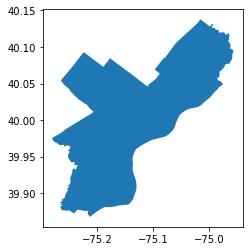

In [59]:
phillyborders.plot()

In [60]:
philly_proj = phillyborders.to_crs("EPSG:2272")

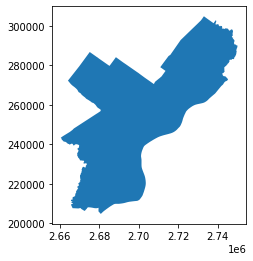

In [61]:
philly_proj.plot()

In [62]:
#f, ax = plt.subplots(figsize=(10,10))
#ax.set_xlabel("feet easting")
#ax.set_ylabel("feet northing")
#ct_shape.boundary.plot(ax=ax, alpha=0.5)
#ct_shape.plot(ax=ax, color="None", edgecolor='k')
#plt.title("Citibike station locations over NYC census tracts")
#cbstationsNY.plot(ax=ax, c="Orange");

# Adding Correct Parcel Data to Licenses with Spatial Join

We will project all Philly data into EPSG 2272.

In [63]:
phillyparcels.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [64]:
junkyards_lic.has_sindex

False

In [65]:
phillyparcels.has_sindex

False

In [66]:
junkyards_lic.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [67]:
# making projected version of Philly parcel data
phillyparc_proj = phillyparcels.to_crs("EPSG:2272")

In [68]:
junkyardlic_proj = junkyards_lic.to_crs(2272)

In [69]:
#spatial joining unprojected parcels to licenses
junkyards_parcel = phillyparcels.sjoin(junkyards_lic, how="inner")

In [70]:
# spatial joining projected parcels and junkyard data (original)
junkyardparcproj = phillyparc_proj.sjoin(junkyardlic_proj, how="inner")

## Checking the results of the spatial join

In [71]:
#unprojected joined geodataframe
junkyards_parcel.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ADDR_SOURC   1086 non-null   object  
 1   MAPREG       1167 non-null   object  
 2   RECMAP       1167 non-null   object  
 3   PARCEL       1166 non-null   object  
 4   PWD_REVIEW   154 non-null    object  
 5   DOR_REVIEW   154 non-null    object  
 6   geometry     1167 non-null   geometry
 7   index_right  1167 non-null   int64   
 8   objectid     1167 non-null   int64   
 9   addressobj   1141 non-null   float64 
 10  address      1167 non-null   object  
 11  unit_type    149 non-null    object  
 12  unit_num     149 non-null    object  
 13  zip          1167 non-null   object  
 14  censustrac   1167 non-null   object  
 15  parcel_id_   1092 non-null   object  
 16  opa_accoun   1051 non-null   object  
 17  opa_owner    1051 non-null   object  
 18  licensenum   116

In [72]:
#making sure it's polygons
junkyards_parcel["geometry"]

939       POLYGON ((-75.21644 39.90869, -75.21653 39.908...
523471    POLYGON ((-75.21911 39.90638, -75.21934 39.905...
597490    POLYGON ((-75.21644 39.90869, -75.21654 39.908...
939       POLYGON ((-75.21644 39.90869, -75.21653 39.908...
523471    POLYGON ((-75.21911 39.90638, -75.21934 39.905...
                                ...                        
602589    POLYGON ((-75.17447 39.96453, -75.17453 39.964...
602589    POLYGON ((-75.17447 39.96453, -75.17453 39.964...
602589    POLYGON ((-75.17447 39.96453, -75.17453 39.964...
602589    POLYGON ((-75.17447 39.96453, -75.17453 39.964...
602589    POLYGON ((-75.17447 39.96453, -75.17453 39.964...
Name: geometry, Length: 1167, dtype: geometry

In [73]:
junkyards_parcel.nunique()

ADDR_SOURC     129
MAPREG         168
RECMAP          84
PARCEL         111
PWD_REVIEW       2
DOR_REVIEW       2
geometry       167
index_right    861
objectid       861
addressobj     168
address        120
unit_type        1
unit_num        12
zip             96
censustrac      47
parcel_id_     118
opa_accoun     113
opa_owner      110
licensenum     861
revenuecod      19
licensetyp      20
rentalcate       0
initialiss     647
mostrecent     639
expiration     303
inactiveda     180
licensesta       5
legalfirst     114
legallastn     124
legalname      390
legalentit       2
business_n     419
business_m     357
geocode_x      124
geocode_y      124
council_di      14
posse_jobi     861
dtype: int64

I tried a left spatial join to see what the differences in records would be. I got more records, fewer unique geometry (which is a little confusing), same number of unique parcels, and 3 more unique business names. Since so much of the data is bad and grouping things by parcel is the most important, I think my original join is fine.

In [74]:
#trying a left join in the hope of getting fewer records, got MORE but fewer unique geometry
#same number of parcels
junkyards_left = junkyards_lic.sjoin(phillyparcels, how="left", predicate="within")

In [75]:
junkyards_left.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1172 entries, 418 to 394342
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   objectid     1172 non-null   int64   
 1   addressobj   1146 non-null   float64 
 2   address      1172 non-null   object  
 3   unit_type    149 non-null    object  
 4   unit_num     149 non-null    object  
 5   zip          1172 non-null   object  
 6   censustrac   1172 non-null   object  
 7   parcel_id_   1097 non-null   object  
 8   opa_accoun   1056 non-null   object  
 9   opa_owner    1056 non-null   object  
 10  licensenum   1172 non-null   object  
 11  revenuecod   1172 non-null   object  
 12  licensetyp   1172 non-null   object  
 13  rentalcate   0 non-null      object  
 14  initialiss   1172 non-null   object  
 15  mostrecent   1172 non-null   object  
 16  expiration   1113 non-null   object  
 17  inactiveda   645 non-null    object  
 18  licensesta   117

In [76]:
junkyards_left.nunique()

objectid       866
addressobj     170
address        122
unit_type        1
unit_num        12
zip             98
censustrac      48
parcel_id_     120
opa_accoun     115
opa_owner      112
licensenum     866
revenuecod      19
licensetyp      20
rentalcate       0
initialiss     649
mostrecent     641
expiration     303
inactiveda     180
licensesta       5
legalfirst     115
legallastn     126
legalname      393
legalentit       2
business_n     422
business_m     360
geocode_x      126
geocode_y      126
council_di      14
posse_jobi     866
geometry       126
index_right    168
ADDR_SOURC     129
MAPREG         168
RECMAP          84
PARCEL         111
PWD_REVIEW       2
DOR_REVIEW       2
dtype: int64

In [77]:
# obvs junkyards left is point geometry
junkyards_left["geometry"].head(5)

418     POINT (-75.22133 39.90702)
418     POINT (-75.22133 39.90702)
2397    POINT (-75.22133 39.90702)
2397    POINT (-75.22133 39.90702)
8475    POINT (-75.17753 40.01428)
Name: geometry, dtype: geometry

## Comparing projecting joined data before and after the joining

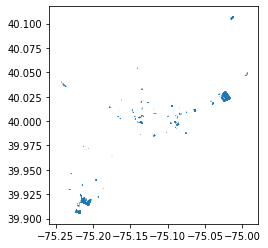

In [78]:
# plot of unprojected parcel + junkyard licenses (note axes)
junkyards_parcel.plot()

In [79]:
junkyards_parcel.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [80]:
junkyardparcel_proj = junkyards_parcel.to_crs(2272)

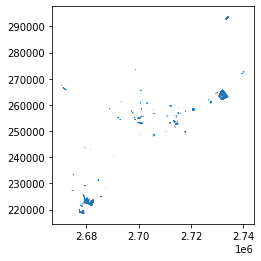

In [81]:
junkyardparcel_proj.plot()

In [82]:
junkyardparcel_proj.tail(10)

,ADDR_SOURC,MAPREG,RECMAP,PARCEL,PWD_REVIEW,DOR_REVIEW,geometry,index_right,objectid,addressobj,...,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,council_di,posse_jobi
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",179969,182790,15771972.0,...,None,None,A & H USED AUTO PARTS INC,Company,A & H USED AUTO PARTS INC,"6255 W PASSYUNK AVE PHILADELPHIA, PA 19153 USA",2.679286e+06,223056.180343,3,9497231
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",124870,126743,15771972.0,...,ANH NGOC,LUONG,LUONG ANH NGOC,Individual,LUONG ANH NGOC,"1529 S 6TH STREET PHILADELPHIA, PA 19147 USA",2.679286e+06,223056.180343,3,9416290
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",87676,88235,15771972.0,...,None,None,CLEAR CHANNEL OUTDOOR,Company,CLEAR CHANNEL OUTDOOR,"9130 STATE RD PHILADELPHIA, PA 19136 USA",2.679286e+06,223056.180343,3,9312311
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",136487,140528,15771972.0,...,None,None,JIMS AUTO RECYCLING INC,Company,JIM'S AUTO RECYCLING,"6299 W. PASSYUNK AVE. PHILADELPHIA, PA 19153 USA",2.679286e+06,223056.180343,3,9426604
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",394138,385054,136736996.0,...,None,None,RICH'S AUTO SALES INC,Company,RICH'S AUTO SALES INC,"6299 Passyunk Avenue Philadelphia, PA 19153 USA",2.679286e+06,223056.180343,3,462983230
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",82976,83604,15857148.0,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,9248555
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",289595,282249,NaN,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,39051846
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",364798,353089,15857148.0,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,163961482
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",364801,353092,133809685.0,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,163963802
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",364800,353091,133809685.0,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,163963796


In [83]:
junkyardparcel_proj.tail(10)

,ADDR_SOURC,MAPREG,RECMAP,PARCEL,PWD_REVIEW,DOR_REVIEW,geometry,index_right,objectid,addressobj,...,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,council_di,posse_jobi
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",179969,182790,15771972.0,...,None,None,A & H USED AUTO PARTS INC,Company,A & H USED AUTO PARTS INC,"6255 W PASSYUNK AVE PHILADELPHIA, PA 19153 USA",2.679286e+06,223056.180343,3,9497231
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",124870,126743,15771972.0,...,ANH NGOC,LUONG,LUONG ANH NGOC,Individual,LUONG ANH NGOC,"1529 S 6TH STREET PHILADELPHIA, PA 19147 USA",2.679286e+06,223056.180343,3,9416290
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",87676,88235,15771972.0,...,None,None,CLEAR CHANNEL OUTDOOR,Company,CLEAR CHANNEL OUTDOOR,"9130 STATE RD PHILADELPHIA, PA 19136 USA",2.679286e+06,223056.180343,3,9312311
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",136487,140528,15771972.0,...,None,None,JIMS AUTO RECYCLING INC,Company,JIM'S AUTO RECYCLING,"6299 W. PASSYUNK AVE. PHILADELPHIA, PA 19153 USA",2.679286e+06,223056.180343,3,9426604
602057,6247 W PASSYUNK AVE,047S200071,047S20,0071,Completed,Completed,"POLYGON ((2679266.293 223243.072, 2679413.183 ...",394138,385054,136736996.0,...,None,None,RICH'S AUTO SALES INC,Company,RICH'S AUTO SALES INC,"6299 Passyunk Avenue Philadelphia, PA 19153 USA",2.679286e+06,223056.180343,3,462983230
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",82976,83604,15857148.0,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,9248555
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",289595,282249,NaN,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,39051846
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",364798,353089,15857148.0,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,163961482
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",364801,353092,133809685.0,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,163963802
602589,2201-09 SPRING GARDEN ST,004N240112,004N24,0112,Completed,Completed,"POLYGON ((2690335.698 240461.367, 2690321.702 ...",364800,353091,133809685.0,...,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,5,163963796


In [84]:
junkyardparcel_proj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ADDR_SOURC   1086 non-null   object  
 1   MAPREG       1167 non-null   object  
 2   RECMAP       1167 non-null   object  
 3   PARCEL       1166 non-null   object  
 4   PWD_REVIEW   154 non-null    object  
 5   DOR_REVIEW   154 non-null    object  
 6   geometry     1167 non-null   geometry
 7   index_right  1167 non-null   int64   
 8   objectid     1167 non-null   int64   
 9   addressobj   1141 non-null   float64 
 10  address      1167 non-null   object  
 11  unit_type    149 non-null    object  
 12  unit_num     149 non-null    object  
 13  zip          1167 non-null   object  
 14  censustrac   1167 non-null   object  
 15  parcel_id_   1092 non-null   object  
 16  opa_accoun   1051 non-null   object  
 17  opa_owner    1051 non-null   object  
 18  licensenum   116

In [85]:
# info on pre-projected geodataframe
junkyardparcproj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ADDR_SOURC   1086 non-null   object  
 1   MAPREG       1167 non-null   object  
 2   RECMAP       1167 non-null   object  
 3   PARCEL       1166 non-null   object  
 4   PWD_REVIEW   154 non-null    object  
 5   DOR_REVIEW   154 non-null    object  
 6   geometry     1167 non-null   geometry
 7   index_right  1167 non-null   int64   
 8   objectid     1167 non-null   int64   
 9   addressobj   1141 non-null   float64 
 10  address      1167 non-null   object  
 11  unit_type    149 non-null    object  
 12  unit_num     149 non-null    object  
 13  zip          1167 non-null   object  
 14  censustrac   1167 non-null   object  
 15  parcel_id_   1092 non-null   object  
 16  opa_accoun   1051 non-null   object  
 17  opa_owner    1051 non-null   object  
 18  licensenum   116

# More Data Cleaning

I'll just keep using junkyardparcproj as the main geodataframe from here. It needs more cleaning, though.

In [86]:
junkyardparcproj.drop(columns=["rentalcate", "index_right", "objectid", 
                               "addressobj"], axis=1, inplace=True)

In [87]:
junkyardparcproj["posse_jobi"]

939         9340849
523471      9340849
597490      9340849
939         9266408
523471      9266408
            ...    
602589     39051846
602589    163963796
602589    163961482
602589      9248555
602589    163963802
Name: posse_jobi, Length: 1167, dtype: object

In [88]:
junkyardparcproj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADDR_SOURC  1086 non-null   object  
 1   MAPREG      1167 non-null   object  
 2   RECMAP      1167 non-null   object  
 3   PARCEL      1166 non-null   object  
 4   PWD_REVIEW  154 non-null    object  
 5   DOR_REVIEW  154 non-null    object  
 6   geometry    1167 non-null   geometry
 7   address     1167 non-null   object  
 8   unit_type   149 non-null    object  
 9   unit_num    149 non-null    object  
 10  zip         1167 non-null   object  
 11  censustrac  1167 non-null   object  
 12  parcel_id_  1092 non-null   object  
 13  opa_accoun  1051 non-null   object  
 14  opa_owner   1051 non-null   object  
 15  licensenum  1167 non-null   object  
 16  revenuecod  1167 non-null   object  
 17  licensetyp  1167 non-null   object  
 18  initialiss  1167 non-null   object  

## Making a trimmed down version for combining with our other data

In [89]:
phillyjunklic = junkyardparcproj.drop(columns=["censustrac", "parcel_id_", 
                                               "revenuecod", "council_di", 
                                               "posse_jobi"])

In [90]:
phillyjunklic.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADDR_SOURC  1086 non-null   object  
 1   MAPREG      1167 non-null   object  
 2   RECMAP      1167 non-null   object  
 3   PARCEL      1166 non-null   object  
 4   PWD_REVIEW  154 non-null    object  
 5   DOR_REVIEW  154 non-null    object  
 6   geometry    1167 non-null   geometry
 7   address     1167 non-null   object  
 8   unit_type   149 non-null    object  
 9   unit_num    149 non-null    object  
 10  zip         1167 non-null   object  
 11  opa_accoun  1051 non-null   object  
 12  opa_owner   1051 non-null   object  
 13  licensenum  1167 non-null   object  
 14  licensetyp  1167 non-null   object  
 15  initialiss  1167 non-null   object  
 16  mostrecent  1167 non-null   object  
 17  expiration  1109 non-null   object  
 18  inactiveda  642 non-null    object  

## Reorganizing and Renaming Columns

There are some very similar columns here and columns whose contents make no sense unless you read the metadata for their source. I'm renaming them to be a little clearer. However, I'm leaving most of the Philly L&I Business License column names as they are in case we need to use them as join/merge keys with other Philly datasets.

In [91]:
#first renaming the business license address column, which is secondary to ADDR_SOURCE
phillyjunklic.rename({"address": "address_licdata"}, axis=1, inplace=True)

In [92]:
phillyjunklic.columns

Index(['ADDR_SOURC', 'MAPREG', 'RECMAP', 'PARCEL', 'PWD_REVIEW', 'DOR_REVIEW',
       'geometry', 'address_licdata', 'unit_type', 'unit_num', 'zip',
       'opa_accoun', 'opa_owner', 'licensenum', 'licensetyp', 'initialiss',
       'mostrecent', 'expiration', 'inactiveda', 'licensesta', 'legalfirst',
       'legallastn', 'legalname', 'legalentit', 'business_n', 'business_m',
       'geocode_x', 'geocode_y'],
      dtype='object')

In [93]:
#renaming the parcel data columns to be clearer and match formatting
phillyjunklic.rename({"ADDR_SOURC": "address", "MAPREG": "parcel_full", 
                      "RECMAP": "map_section", "PARCEL": "map_parcel",
                      "PWD_REVIEW": "PWD_review", "DOR_REVIEW": "DOR_review"},
                     axis=1, inplace=True)

In [94]:
phillyjunklic.columns

Index(['address', 'parcel_full', 'map_section', 'map_parcel', 'PWD_review',
       'DOR_review', 'geometry', 'address_licdata', 'unit_type', 'unit_num',
       'zip', 'opa_accoun', 'opa_owner', 'licensenum', 'licensetyp',
       'initialiss', 'mostrecent', 'expiration', 'inactiveda', 'licensesta',
       'legalfirst', 'legallastn', 'legalname', 'legalentit', 'business_n',
       'business_m', 'geocode_x', 'geocode_y'],
      dtype='object')

In [98]:
# moving geometry to end
phillyjunklic = phillyjunklic[['address', 'map_section', 'map_parcel', 
                               'parcel_full', 'PWD_review', 'DOR_review',
                               'address_licdata', 'unit_type', 'unit_num',
                               'zip', 'opa_accoun', 'opa_owner', 'licensenum', 
                               'licensetyp', 'initialiss', 'mostrecent', 
                               'expiration', 'inactiveda', 'licensesta', 
                               'legalfirst', 'legallastn', 'legalname', 
                               'legalentit', 'business_n', 'business_m', 
                               'geocode_x', 'geocode_y', 'geometry']]

In [102]:
phillyjunklic.tail()

,address,map_section,map_parcel,parcel_full,PWD_review,DOR_review,address_licdata,unit_type,unit_num,zip,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Active,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Active,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."


In [100]:
# "address" (0) is now the name of the correct and standard-formatting addresses
phillyjunklic.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   address          1086 non-null   object  
 1   map_section      1167 non-null   object  
 2   map_parcel       1166 non-null   object  
 3   parcel_full      1167 non-null   object  
 4   PWD_review       154 non-null    object  
 5   DOR_review       154 non-null    object  
 6   address_licdata  1167 non-null   object  
 7   unit_type        149 non-null    object  
 8   unit_num         149 non-null    object  
 9   zip              1167 non-null   object  
 10  opa_accoun       1051 non-null   object  
 11  opa_owner        1051 non-null   object  
 12  licensenum       1167 non-null   object  
 13  licensetyp       1167 non-null   object  
 14  initialiss       1167 non-null   object  
 15  mostrecent       1167 non-null   object  
 16  expiration       1109 non-null

In [103]:
#resetting index values so they're continuous
phillyjunklic.reset_index(inplace = True)

In [104]:
phillyjunklic.tail()

,index,address,map_section,map_parcel,parcel_full,PWD_review,DOR_review,address_licdata,unit_type,unit_num,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
1162,602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1163,602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1164,602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,...,Active,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1165,602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1166,602589,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,...,Active,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."


In [107]:
 phillyjunklic = phillyjunklic.drop("index", axis=1)

In [118]:
phillyjunklic.tail()

,address,map_section,map_parcel,parcel_full,PWD_review,DOR_review,address_licdata,unit_type,unit_num,zip,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
1162,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1163,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1164,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Active,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1165,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
1166,2201-09 SPRING GARDEN ST,004N24,0112,004N240112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,...,Active,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."


In [119]:
phillyjunklic.nunique()

address            129
map_section         84
map_parcel         111
parcel_full        168
PWD_review           2
DOR_review           2
address_licdata    120
unit_type            1
unit_num            12
zip                 96
opa_accoun         113
opa_owner          110
licensenum         861
licensetyp          20
initialiss         647
mostrecent         639
expiration         303
inactiveda         180
licensesta           5
legalfirst         114
legallastn         124
legalname          390
legalentit           2
business_n         419
business_m         357
geocode_x          124
geocode_y          124
geometry           167
dtype: int64

# Exporting Junkyard Business License Data and Locations (as Parcels)

I'm going to save this to Google Drive and our Github folder.



In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
drive.mount("content")

Mounted at content


In [111]:
cd /content/content/MyDrive/Colab Notebooks

/content/content/MyDrive/Colab Notebooks


In [112]:
ls

 09_26Class_Geopandas.ipynb
 09_28_Class_MoreGeoPandas.ipynb
 10_03_Class_LinearRegression.ipynb
 AutocorrelationCensus.ipynb
'Carl Jung.jpg'
 ClassDemoBusTimes.ipynb
'Copy of MidtermLathamWolk DEPDataNotebook.ipynb'
'HW3 HW3.ipynb'
'HW4 HW4.ipynb'
'HW5 HW5_TimeSeriesClustering.ipynb'
'HW6\HW6_RandomForestsChicago (1).ipynb'
'HW6\HW6_RandomForestsChicago.ipynb'
'HW6\HW6_RandomForestsDC.ipynb'
'HW6\HW6_RandomForestsDC Take 2.ipynb'
'HW7 HW7_deepdream.ipynb'
'HW HW5_timeSeriesClustering.ipynb'
 kaggle.json
'MidtermLathamWolk 311 Requests Notebook.ipynb'
'MidtermLathamWolk DEPDataNotebook.ipynb'
'MidtermLathamWolk LanthamWolkMidtermData.ipynb'
'MidtermLathamWolk LIBusinessLicenses.ipynb'
'MidtermLathamWolk LIViolations.ipynb'
 PhillyJunkLicensesLocations.csv
 PhillyJunkLicensesLocations.geojson
 PUS2022_1031_MoransINYCWomens.ipynb
 PUS22_Class2and3.ipynb
 TitanicKaggleFraggleRockData/
 TitanicRandomForestsClassDemo.ipynb
 titanic.zip
 Untitled
 Untitled0.ipynb
'Untitled (1)'
 Untitled1.ip

In [ ]:
#example code for exporting to csv
#df.to_csv( "/Drive Path/df.csv", index=False, encoding='utf-8-sig')

In [113]:
phillyjunklic.to_csv("/content/content/MyDrive/Colab Notebooks/PhillyJunkLicensesLocations.csv", )

In [114]:
phillyjunklic.to_file("/content/content/MyDrive/Colab Notebooks/PhillyJunkLicensesLocations.geojson", driver="GeoJSON")

## Let's see if that works...

In [ ]:
cd /content/content/MyDrive/Colab Notebooks

In [115]:
ls

 09_26Class_Geopandas.ipynb
 09_28_Class_MoreGeoPandas.ipynb
 10_03_Class_LinearRegression.ipynb
 AutocorrelationCensus.ipynb
'Carl Jung.jpg'
 ClassDemoBusTimes.ipynb
'Copy of MidtermLathamWolk DEPDataNotebook.ipynb'
'HW3 HW3.ipynb'
'HW4 HW4.ipynb'
'HW5 HW5_TimeSeriesClustering.ipynb'
'HW6\HW6_RandomForestsChicago (1).ipynb'
'HW6\HW6_RandomForestsChicago.ipynb'
'HW6\HW6_RandomForestsDC.ipynb'
'HW6\HW6_RandomForestsDC Take 2.ipynb'
'HW7 HW7_deepdream.ipynb'
'HW HW5_timeSeriesClustering.ipynb'
 kaggle.json
'MidtermLathamWolk 311 Requests Notebook.ipynb'
'MidtermLathamWolk DEPDataNotebook.ipynb'
'MidtermLathamWolk LanthamWolkMidtermData.ipynb'
'MidtermLathamWolk LIBusinessLicenses.ipynb'
'MidtermLathamWolk LIViolations.ipynb'
 PhillyJunkLicensesLocations.csv
 PhillyJunkLicensesLocations.geojson
 PUS2022_1031_MoransINYCWomens.ipynb
 PUS22_Class2and3.ipynb
 TitanicKaggleFraggleRockData/
 TitanicRandomForestsClassDemo.ipynb
 titanic.zip
 Untitled
 Untitled0.ipynb
'Untitled (1)'
 Untitled1.ip

## Importing the GeoJSON into geopandas to test

Originally, I exported/imported this as a csv, but then I heard Dr. Bianco say that can alter some of the more precise numbers and to use GeoJSON.

Here's the CSV code:


```
# first read in data as csv
testjunk = pd.read_csv("PhillyJunkLicensesLocations.csv")

# then build geodataframe from imported csv dataframe
testjunk = gpd.GeoDataFrame(testjunk, geometry=gpd.GeoSeries.from_wkt(testjunk["geometry"]), crs="epsg:2272")
```



In [120]:
testjunk = gpd.read_file("PhillyJunkLicensesLocations.geojson")

In [121]:
# testing that data matches
testjunk.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   address          1086 non-null   object  
 1   map_section      1167 non-null   object  
 2   map_parcel       1166 non-null   object  
 3   parcel_full      1167 non-null   object  
 4   PWD_review       154 non-null    object  
 5   DOR_review       154 non-null    object  
 6   address_licdata  1167 non-null   object  
 7   unit_type        149 non-null    object  
 8   unit_num         149 non-null    object  
 9   zip              1167 non-null   object  
 10  opa_accoun       1051 non-null   object  
 11  opa_owner        1051 non-null   object  
 12  licensenum       1167 non-null   object  
 13  licensetyp       1167 non-null   object  
 14  initialiss       1167 non-null   object  
 15  mostrecent       1167 non-null   object  
 16  expiration       1109 non-null   o

# Conclusions about the variable: use parcels!
Parcel_full is probably the most authoritative and useful column. As you can see from the head of the dataframe, some parcels have no address even in the official parcel + address records. From looking at this data in another notebook, some addresses share a parcel. For example, "120-130 Bigparcel St" could be an address for one parcel, and then bad records or businesses sharing a site might use 123 Bigparcel St and 125 Bigparcel St for the same piece of land or even the same business. BUT some addresses have multiple parcels! See 3111 Grays Ferry Ave when I group by parcel below: it shows up as the address for multiple parcels. That address is a junkyard under I-76 and next to a freight line, so it's no surprise that it's a very weird lot.

Anyway, since some parcels have no address and the parcel names are less confusing than addresses, the simplest way to deal with this for the full set of data is just using parcels.

In [122]:
testjunk.head()

,address,map_section,map_parcel,parcel_full,PWD_review,DOR_review,address_licdata,unit_type,unit_num,zip,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
0,None,047S11,0010,047S110010,None,None,6850 ESSINGTON AVE,None,None,19153-3413,...,Inactive,None,None,SUPPORT TERMINALS OPER PRTS LP,Company,SUPPORT TERMINALS OPER PRTS LP,"17304 PRESTON RD 1000 DALLAS, TX 75252 USA",2.678437e+06,218972.547295,"POLYGON ((2679160.849 219790.732, 2679137.703 ..."
1,None,047S17,0035,047S170035,None,None,6850 ESSINGTON AVE,None,None,19153-3413,...,Inactive,None,None,SUPPORT TERMINALS OPER PRTS LP,Company,SUPPORT TERMINALS OPER PRTS LP,"17304 PRESTON RD 1000 DALLAS, TX 75252 USA",2.678437e+06,218972.547295,"POLYGON ((2678435.960 218926.501, 2678379.218 ..."
2,None,047S17,0026,047S170026,None,None,6850 ESSINGTON AVE,None,None,19153-3413,...,Inactive,None,None,SUPPORT TERMINALS OPER PRTS LP,Company,SUPPORT TERMINALS OPER PRTS LP,"17304 PRESTON RD 1000 DALLAS, TX 75252 USA",2.678437e+06,218972.547295,"POLYGON ((2679159.954 219790.563, 2679136.835 ..."
3,None,047S11,0010,047S110010,None,None,6850 ESSINGTON AVE,None,None,19153-3413,...,Inactive,None,None,CHRIS AUTO PARTS II,Company,CHRIS AUTO PARTS II,"6750 ESSINGTON AVE PHILADELPHIA, PA 19153 USA",2.678437e+06,218972.547295,"POLYGON ((2679160.849 219790.732, 2679137.703 ..."
4,None,047S17,0035,047S170035,None,None,6850 ESSINGTON AVE,None,None,19153-3413,...,Inactive,None,None,CHRIS AUTO PARTS II,Company,CHRIS AUTO PARTS II,"6750 ESSINGTON AVE PHILADELPHIA, PA 19153 USA",2.678437e+06,218972.547295,"POLYGON ((2678435.960 218926.501, 2678379.218 ..."


In [123]:
testjunk.crs

<Derived Projected CRS: EPSG:2272>
Name: NAD83 / Pennsylvania South (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Pennsylvania - counties of Adams; Allegheny; Armstrong; Beaver; Bedford; Berks; Blair; Bucks; Butler; Cambria; Chester; Cumberland; Dauphin; Delaware; Fayette; Franklin; Fulton; Greene; Huntingdon; Indiana; Juniata; Lancaster; Lawrence; Lebanon; Lehigh; Mifflin; Montgomery; Northampton; Perry; Philadelphia; Schuylkill; Snyder; Somerset; Washington; Westmoreland; York.
- bounds: (-80.53, 39.71, -74.72, 41.18)
Coordinate Operation:
- name: SPCS83 Pennsylvania South zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

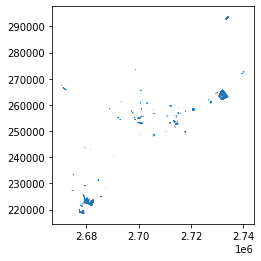

In [124]:
testjunk.plot()

# Cleaning the Licenses Data for the Model

In [116]:
#grouping by business name
junkybiz = phillyjunklic.groupby("business_n").first()
junkybiz

,address,map_section,map_parcel,parcel_full,PWD_review,DOR_review,address_licdata,unit_type,unit_num,zip,...,inactiveda,licensesta,legalfirst,legallastn,legalname,legalentit,business_m,geocode_x,geocode_y,geometry
business_n,,,,,,,,,,,,,,,,,,,,,
2 GUYS AUTO SALVAGE & PARTS,3221 S 63RD ST,047S20,0087,047S200087,Completed,Completed,3221 S 63RD ST,None,None,19143-0000,...,2018-12-31,Inactive,None,None,2 GUYS AUTO SALVAGE & PARTS,Company,"3221 S 63RD ST PHILA, PA 19153 USA",2.679094e+06,223319.868425,"POLYGON ((2679174.965 223637.979, 2679159.012 ..."
22ND ST AUTO,3224 N 22ND ST,040N17,0026,040N170026,None,None,3240 N 22ND ST,None,None,19140-4702,...,2016-10-30,Inactive,MARK,LOVE,LOVE MARK,Individual,"3224 N 22ND ST PHILADELPHIA, PA 19143 USA",2.692239e+06,255068.941575,"POLYGON ((2692333.431 254925.500, 2692284.622 ..."
232 NORTH CALIFORNIA AVE CORP,None,058N13,0007,058N130007,None,None,4036 POPLAR ST,None,None,19104-1242,...,2020-10-06,Inactive,None,None,232 NORTH CALIFORNIA AVE CORP,Company,"1250 Conshohocken Rd Conshohocken, PA 19428 USA",2.681523e+06,242972.716541,"POLYGON ((2681557.225 242884.612, 2681508.306 ..."
4 A'S USED AUTO PARTS INC,3300 S 61ST ST,047S20,0054,047S200054,Completed,Completed,3300 S 61ST ST,None,None,19153-3513,...,2017-03-01,Inactive,None,None,4 A'S USED AUTO PARTS INC,Company,"3340 S. 61ST STREET PHILADELPHIA, PA 19153 USA",2.680407e+06,223577.557603,"POLYGON ((2680522.852 223646.488, 2680426.306 ..."
5TH STREET AUTO PARTS INC,3105-17 N 5TH ST,038N24,0037,038N240037,Completed,Completed,3105 N 5TH ST,None,None,19133-2823,...,2018-06-29,Inactive,None,None,5TH STREET AUTO PARTS INC,Company,"3105 N 05TH ST PHILADELPHIA, PA 19133 USA",2.700112e+06,253127.421618,"POLYGON ((2700194.769 253187.908, 2700233.096 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOLIO JR ROBERT,3331 S 61ST ST,047S22,0024,047S220024,None,None,3501 S 61ST ST,None,None,19153-3522,...,2020-02-29,Inactive,ROBERT,VOLIO JR,VOLIO JR ROBERT,Individual,"3506 S 61ST STREET PHILADELPHIA, PA 19153 USA",2.680347e+06,224150.290727,"POLYGON ((2680511.237 224373.253, 2680377.850 ..."
WHAT YOU NEED INC,3331 S 61ST ST,047S22,0024,047S220024,None,None,3501 S 61ST ST,None,None,19153-3522,...,2012-07-24,Inactive,None,None,WHAT YOU NEED INC,Company,"5719 WALNUT STREET PHILADELPHIA, PA 19139 USA",2.680347e+06,224150.290727,"POLYGON ((2680511.237 224373.253, 2680377.850 ..."
WOLDORF JORDAN,3640 N 2ND ST,045N17,0038,045N170038,None,None,3636 N 2ND ST,None,None,19140-4605,...,None,Inactive,JORDAN,WOLDORF,WOLDORF JORDAN,Individual,"3644 02ND ST PHILADELPHIA, PA 19140 USA",2.701771e+06,255982.602236,"POLYGON ((2701838.728 255999.970, 2701831.454 ..."


So there are 419 different business names here

In [117]:
junkybiz.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 419 entries, 2 GUYS AUTO SALVAGE & PARTS to ZOMBIES BODY REMOVAL
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   address          410 non-null    object  
 1   map_section      419 non-null    object  
 2   map_parcel       419 non-null    object  
 3   parcel_full      419 non-null    object  
 4   PWD_review       87 non-null     object  
 5   DOR_review       87 non-null     object  
 6   address_licdata  419 non-null    object  
 7   unit_type        62 non-null     object  
 8   unit_num         62 non-null     object  
 9   zip              419 non-null    object  
 10  opa_accoun       372 non-null    object  
 11  opa_owner        372 non-null    object  
 12  licensenum       419 non-null    object  
 13  licensetyp       419 non-null    object  
 14  initialiss       419 non-null    object  
 15  mostrecent       419 non-null    object  
 16

In [ ]:
#junkparcelname = phillyjunklic.groupby(["parcel_full", "business_n"]).size().plot()

I was trying to get a sense of how much business name, address, and parcel are the same. For example, will the same business name mostly have the same address and parcel, or will it have such varied addresses that we'd need to look for bad data or changes of business location? Will the same parcel have a consistent address? Will the same address have a consistent parcel? This isn't necessarily important to our research at the moment, but it's something to dig into more if we go further.

In [126]:
# trying to look at details, very messy!
print(list(phillyjunklic.groupby("parcel_full")))

[('004N240112',                        address map_section map_parcel parcel_full PWD_review  \
1162  2201-09 SPRING GARDEN ST      004N24       0112  004N240112  Completed   
1163  2201-09 SPRING GARDEN ST      004N24       0112  004N240112  Completed   
1164  2201-09 SPRING GARDEN ST      004N24       0112  004N240112  Completed   
1165  2201-09 SPRING GARDEN ST      004N24       0112  004N240112  Completed   
1166  2201-09 SPRING GARDEN ST      004N24       0112  004N240112  Completed   

     DOR_review        address_licdata unit_type unit_num         zip  ...  \
1162  Completed  2201 SPRING GARDEN ST      None     None  19130-3511  ...   
1163  Completed  2201 SPRING GARDEN ST      None     None  19130-3511  ...   
1164  Completed  2201 SPRING GARDEN ST      None     None  19130-3511  ...   
1165  Completed  2201 SPRING GARDEN ST      None     None  19130-3511  ...   
1166  Completed  2201 SPRING GARDEN ST      None     None  19130-3511  ...   

     licensesta legalfirst legalla

In [127]:
junkyparcels = phillyjunklic.groupby("parcel_full").first()

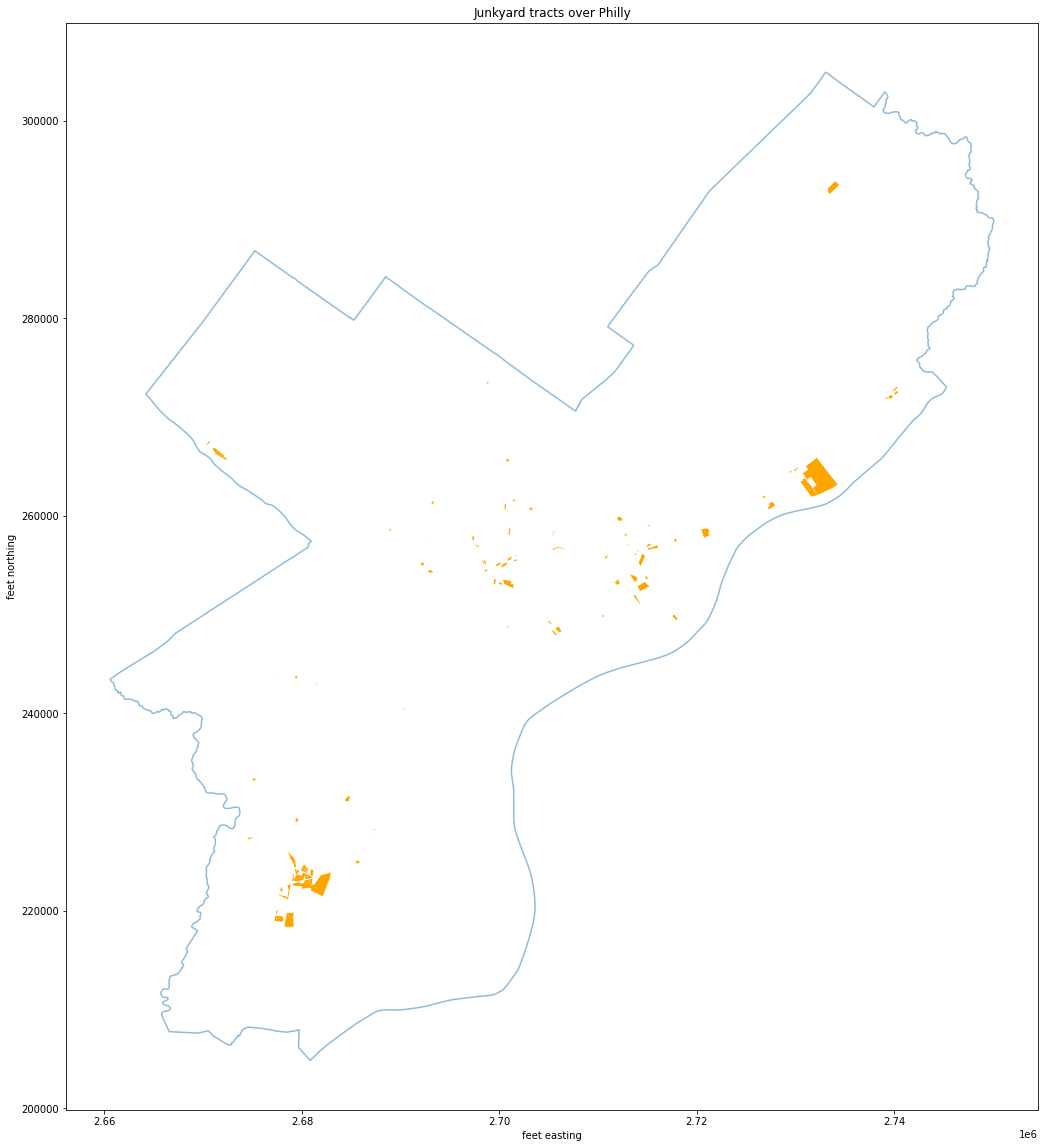

In [128]:
f, ax = plt.subplots(figsize=(20,20))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
plt.title("Junkyard tracts over Philly")
junkyparcels.plot(ax=ax, color="Orange")
philly_proj.boundary.plot(ax=ax, alpha=0.5)

Unsurprisingly, the junkyards are concentrated in Southwest Philly, the Riverwards near the Delaware River, and North Philly.

In [129]:
junkyparcels

,address,map_section,map_parcel,PWD_review,DOR_review,address_licdata,unit_type,unit_num,zip,opa_accoun,...,licensesta,legalfirst,legallastn,legalname,legalentit,business_n,business_m,geocode_x,geocode_y,geometry
parcel_full,,,,,,,,,,,,,,,,,,,,,
004N240112,2201-09 SPRING GARDEN ST,004N24,0112,Completed,Completed,2201 SPRING GARDEN ST,None,None,19130-3511,882723900,...,Inactive,None,None,LINNETT'S GULF INC,Company,LINNETT'S GULF INC,"2201 SPRING GARDEN ST PHILADELPHIA, PA 19130 USA",2.690249e+06,240420.666163,"POLYGON ((2690335.698 240461.367, 2690321.702 ..."
009S060029,1056 S 31ST ST,009S06,0029,None,None,1056 S 31ST ST,None,None,19121-0000,885408700,...,Inactive,JOHN,MC CANN JR,MC CANN JR JOHN,Individual,T/A LITTLE MO,"1114 31ST ST PHILADELPHIA, PA 19146 USA",2.684776e+06,231458.753416,"POLYGON ((2684793.810 231346.359, 2684722.606 ..."
009S060032,3111 GRAYS FERRY AVE,009S06,0032,None,None,3111 GRAYS FERRY AVE,None,None,19146-2706,882971230,...,Inactive,None,None,UC TECH INC,Company,UC TECH INC,"3111 GRAYS FERRY AVE PHILADELPHIA, PA 19146 USA",2.684602e+06,231312.000000,"POLYGON ((2684634.992 231397.724, 2684640.581 ..."
009S060037,1056 S 31ST ST,009S06,0037,None,None,1056 S 31ST ST,None,None,19121-0000,885408700,...,Inactive,JOHN,MC CANN JR,MC CANN JR JOHN,Individual,T/A LITTLE MO,"1114 31ST ST PHILADELPHIA, PA 19146 USA",2.684776e+06,231458.753416,"POLYGON ((2684793.810 231346.359, 2684722.606 ..."
009S060043,3111 GRAYS FERRY AVE,009S06,0043,None,None,3111 GRAYS FERRY AVE,None,None,19146-2706,882971230,...,Inactive,None,None,UC TECH INC,Company,UC TECH INC,"3111 GRAYS FERRY AVE PHILADELPHIA, PA 19146 USA",2.684602e+06,231312.000000,"POLYGON ((2684634.992 231397.724, 2684708.683 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150N240018,None,150N24,0018,None,None,5112 UMBRIA ST,None,None,19128-4344,884629912,...,Inactive,None,None,CLEAR CHANNEL OUTDOOR,Company,MATT BRADLEY,"9130 STATE RD PHILADELPHIA, PA 19136 USA",2.671240e+06,266612.192963,"POLYGON ((2672176.106 266044.413, 2672100.590 ..."
150N240031,5112 UMBRIA ST,150N24,0031,None,None,5112 UMBRIA ST,None,None,19128-4344,884629912,...,Inactive,None,None,CLEAR CHANNEL OUTDOOR,Company,MATT BRADLEY,"9130 STATE RD PHILADELPHIA, PA 19136 USA",2.671240e+06,266612.192963,"POLYGON ((2671287.317 266579.049, 2671213.614 ..."
150N240050,5112 UMBRIA ST,150N24,0050,Completed,Completed,5112 UMBRIA ST,None,None,19128-4344,884629912,...,Inactive,None,None,CLEAR CHANNEL OUTDOOR,Company,MATT BRADLEY,"9130 STATE RD PHILADELPHIA, PA 19136 USA",2.671240e+06,266612.192963,"POLYGON ((2671285.560 266581.577, 2671198.612 ..."
